# Smart Cities: Predicting Human movement using Geolocation Data and a Deep Recurrent Neural Network

### Global urbanisation is on the rise; 50% of the world's population now live in cities. According to the UN, this number will increase to 60% by 2030. 

### Whilst this creates great opportunities for cities, it also poses challenges to infrastructure, congestion and pollution. 

### More data than ever before is now available on how citizens of a city move around. Here we look at a dataset with nearly a million anonymised geolocation records from Atlanta, Georgia in 2018. 

### The goal is to be able predict how many people will be in the 'city centre' between 3pm and 4pm.

In [1]:
#imports
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
from matplotlib import style
style.use('fivethirtyeight')

#colors for visualisation
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#dbdb8d'], dtype='<U7')

### Load training data:

In [3]:
df = pd.read_csv('./data_training.csv')

In [4]:
print(df.shape)
df.head(15) #show first 15 rows

(814262, 8)


,Unnamed: 0,hash,time_entry,time_exit,x_entry,y_entry,x_exit,y_exit
0,0,0000a8602cf2def930488dee7cdad104_1,07:04:31,07:08:32,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07
1,1,0000a8602cf2def930488dee7cdad104_1,07:20:34,07:25:42,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07
2,2,0000a8602cf2def930488dee7cdad104_1,07:53:32,08:03:25,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07
3,3,0000a8602cf2def930488dee7cdad104_1,08:17:50,08:37:23,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07
4,4,0000a8602cf2def930488dee7cdad104_1,14:38:09,14:38:09,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07
5,5,0000a8602cf2def930488dee7cdad104_1,15:02:31,15:18:33,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07
6,6,0000cf177130469eeac79f67b6bcf3df_9,14:29:23,14:29:23,3.749450e+06,-1.926506e+07,3.749450e+06,-1.926506e+07
7,7,0000cf177130469eeac79f67b6bcf3df_9,14:39:49,14:39:49,3.749090e+06,-1.926726e+07,3.749090e+06,-1.926726e+07
8,8,0000cf177130469eeac79f67b6bcf3df_9,14:50:14,14:50:14,3.749042e+06,-1.926632e+07,3.749042e+06,-1.926632e+07
9,9,0000cf177130469eeac79f67b6bcf3df_9,15:00:32,15:29:48,3.749088e+06,-1.926605e+07,3.749610e+06,-1.926594e+07


### Initial Data Processing

We can see that the data contains ~814,000 geolocation trajectories from devices in the city, each of which have an **entry/exit time, entry x/y coordinates and exit x/y coordinates**. 

Often **more than one trajectory is associated with the same hash**, meaning that these trajectories are from the same device on the same day. Therefore we can trace the movement of each hash (i.e. **each person**) over the course of the day.

**Some trajectories have exactly the same entry and exit times**. These therefore just give us static locations of where somebody was at some point. **Others give us actual journeys**, with different start and finish points.

### The final trajectory of each device ends between 3pm and 4pm. It is the location of this endpoint which we will try to predict!

Let's **replace the 'hash' column** with something easier to read:

In [5]:
df['device'] = pd.factorize(df['hash'])[0]
print('The total number of devices in the training data is', np.max(df['device'])+1)

df = df.drop(['Unnamed: 0', 'hash'], axis=1)
df.head(10)

The total number of devices in the training data is 134063


,time_entry,time_exit,x_entry,y_entry,x_exit,y_exit,device
0,07:04:31,07:08:32,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0
1,07:20:34,07:25:42,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0
2,07:53:32,08:03:25,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0
3,08:17:50,08:37:23,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0
4,14:38:09,14:38:09,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0
5,15:02:31,15:18:33,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07,0
6,14:29:23,14:29:23,3.749450e+06,-1.926506e+07,3.749450e+06,-1.926506e+07,1
7,14:39:49,14:39:49,3.749090e+06,-1.926726e+07,3.749090e+06,-1.926726e+07,1
8,14:50:14,14:50:14,3.749042e+06,-1.926632e+07,3.749042e+06,-1.926632e+07,1
9,15:00:32,15:29:48,3.749088e+06,-1.926605e+07,3.749610e+06,-1.926594e+07,1


**In total there are 134063 devices in the training data**. Now plot a histogram of how many trajectories each device has:

The minimum number of trajectories per device is 1
The maximum number of trajectories per device is 20
The mean number of trajectories per device is 6.07
The median number of trajectories per device is 5.0


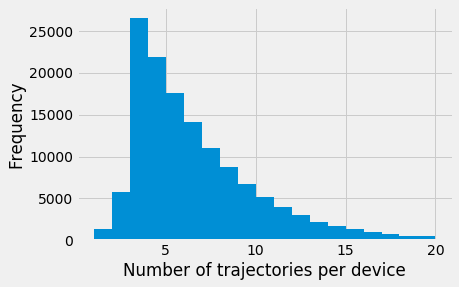

In [6]:
print('The minimum number of trajectories per device is', np.round(np.min(df['device'].value_counts().values)))
print('The maximum number of trajectories per device is', np.round(np.max(df['device'].value_counts().values)))
print('The mean number of trajectories per device is', np.round(np.mean(df['device'].value_counts().values),2))
print('The median number of trajectories per device is', np.round(np.median(df['device'].value_counts().values)))

plt.hist(df['device'].value_counts().values, bins=19)
plt.xlabel('Number of trajectories per device')
plt.ylabel('Frequency')
plt.show()

**We know that the 'city centre' of Atlanta corresponds to having a location**:

- 3750901.5068 < x < 3770901.5068
- -19268905.6133 < y < -19208905.6133

Let's scale the data so this becomes

- -1 < x < 1
- -1 < y < 1

In [7]:
df['x_entry_c'] = (df['x_entry'] - 3760901.5068)/10000
df['x_exit_c'] = (df['x_exit'] - 3760901.5068)/10000
df['y_entry_c'] = (df['y_entry'] + 19238905.6133)/30000
df['y_exit_c'] = (df['y_exit'] + 19238905.6133)/30000

df = df.drop(['x_entry', 'x_exit', 'y_entry', 'y_exit'], axis=1)
df.head(10)

,time_entry,time_exit,device,x_entry_c,x_exit_c,y_entry_c,y_exit_c
0,07:04:31,07:08:32,0,-0.988774,-1.057569,4.830832,3.418856
1,07:20:34,07:25:42,0,-1.696432,-1.592682,-2.785398,-2.691936
2,07:53:32,08:03:25,0,-1.603369,-1.608601,-1.821977,-1.797851
3,08:17:50,08:37:23,0,-1.602144,-1.609269,-1.779472,-1.719366
4,14:38:09,14:38:09,0,-1.599250,-1.599250,-1.555979,-1.555979
5,15:02:31,15:18:33,0,-1.595688,-1.611606,-1.430941,-1.419091
6,14:29:23,14:29:23,1,-1.145178,-1.145178,-0.871651,-0.871651
7,14:39:49,14:39:49,1,-1.181134,-1.181134,-0.945248,-0.945248
8,14:50:14,14:50:14,1,-1.185921,-1.185921,-0.913976,-0.913976
9,15:00:32,15:29:48,1,-1.181356,-1.129148,-0.904824,-0.901011


Finally, we need to turn 'time_entry' and 'time_exit' into something useful. **Since we are looking at cyclic daily movement of devices**, the most sensible things to do is to **encode the entry/exit times using sin and cos functions**. After all, 3pm is actually closer to 12am than to 5am!

In [8]:
#change entry/exit times to sin and cos time
secs_day = 86400
ftr = [3600,60,1]

seconds_entry = [sum([a*b for a,b in zip(ftr,map(int,df['time_entry'][i].split(':')))]) 
                 for i in range(df.shape[0])]
seconds_exit = [sum([a*b for a,b in zip(ftr,map(int,df['time_exit'][i].split(':')))]) 
                for i in range(df.shape[0])]

df['entry_time_sin'] = np.sin(2*np.pi*np.array(seconds_entry)/secs_day)
df['entry_time_cos'] = np.cos(2*np.pi*np.array(seconds_entry)/secs_day)
df['exit_time_sin'] = np.sin(2*np.pi*np.array(seconds_exit)/secs_day)
df['exit_time_cos'] = np.cos(2*np.pi*np.array(seconds_exit)/secs_day)

df = df.drop(['time_entry', 'time_exit'], axis=1)
df.head(10)

,device,x_entry_c,x_exit_c,y_entry_c,y_exit_c,entry_time_sin,entry_time_cos,exit_time_sin,exit_time_cos
0,0,-0.988774,-1.057569,4.830832,3.418856,0.960638,-0.277804,0.955622,-0.294596
1,0,-1.696432,-1.592682,-2.785398,-2.691936,0.938844,-0.344343,0.930897,-0.365283
2,0,-1.603369,-1.608601,-1.821977,-1.797851,0.879787,-0.475368,0.858475,-0.512855
3,0,-1.602144,-1.609269,-1.779472,-1.719366,0.824538,-0.565807,0.773333,-0.634000
4,0,-1.599250,-1.599250,-1.555979,-1.555979,-0.636583,-0.771208,-0.636583,-0.771208
5,0,-1.595688,-1.611606,-1.430941,-1.419091,-0.714829,-0.699300,-0.761962,-0.647621
6,1,-1.145178,-1.145178,-0.871651,-0.871651,-0.606625,-0.794988,-0.606625,-0.794988
7,1,-1.181134,-1.181134,-0.945248,-0.945248,-0.642175,-0.766558,-0.642175,-0.766558
8,1,-1.185921,-1.185921,-0.913976,-0.913976,-0.676340,-0.736589,-0.676340,-0.736589
9,1,-1.181356,-1.129148,-0.904824,-0.901011,-0.708750,-0.705459,-0.792822,-0.609454


Our data is now suitably encoded for the task at hand. **Let's try and visualise what is going on**! 

### Data Visualisation

Here we create a 3-dimensional array with shape **(number_devices, number_trajectories, number_features)** containing all the training data, and a 2-dimensional array with shape **(number_devices, number_features)** containing just the final trajectory for each device.

In [9]:
device_ids = df['device'].tolist()

#remove device column and reorder columns
df = df.drop(['device'], axis=1)
df = df[['entry_time_sin', 'entry_time_cos', 'exit_time_sin', 'exit_time_cos', 
         'x_entry_c', 'y_entry_c', 'x_exit_c', 'y_exit_c']]

#get list of how many trajectories for each device
count = Counter(device_ids)
seq = list(count.values())

#initalise arrays
n_devices = 134063
n_trajectories = 20
n_features = 8
final_states = np.zeros((n_devices, n_features))
data = np.zeros((n_devices, n_trajectories, n_features))

#put data in arrays
ind = 0
z = df.values.copy()
for i in range(n_devices):
    x = z[ind:ind+seq[i]] #take trajectories from the device
    final_states[i,:] = x[-1] #take final trajectory
    x = np.pad(x, [[0,n_trajectories-x.shape[0]],[0,0]], mode='constant') #pad with zeros
    data[i,:,:] = x
    ind += seq[i] #move to next device

seq = np.array(seq)

**Let's plot** what some different devices are doing over the course of a day...

In [10]:
def plot_device(devices, data, seq):
    for n in devices:
        d = data[n] #take a device
        traj_x = np.array(d[:,np.r_[4,6]]) #extract x coordinates
        traj_y = np.array(d[:,np.r_[5,7]]) #extract y coordinates

        plt.figure(figsize=(5,5)) #create figure
        for i in range(seq[n]):
            if traj_x[i][0] == traj_x[i][1]:
                plt.scatter(traj_x[i], traj_y[i], c=colors[i])
                plt.text(-.9+(i*.1), 1.1, s=str(i), color=colors[i], fontsize=16, weight='bold')
            else:
                plt.plot(traj_x[i], traj_y[i], c=colors[i])
                plt.scatter(traj_x[i], traj_y[i], c=colors[i])
                plt.quiver(traj_x[i][0], traj_y[i][0], 
                           traj_x[i][1]-traj_x[i][0], traj_y[i][1]-traj_y[i][0], 
                           angles='xy', color=colors[i], headwidth=8) #add arrows
                plt.text(-.9+(i*.1), 1.1, s=str(i), color=colors[i], fontsize=16, weight='bold')

        plt.axvline(x=-1, color='k', linestyle='dashed', linewidth=2)
        plt.axvline(x=1, color='k', linestyle='dashed', linewidth=2)
        plt.axhline(y=-1, color='k', linestyle='dashed', linewidth=2)
        plt.axhline(y=1, color='k', linestyle='dashed', linewidth=2)
        plt.fill_between(x=(-1,1), y1=(-1,-1), y2=(1,1), color='r', 
                         alpha=0.1, label='City Centre') #shade city centre
        plt.legend(loc=7, bbox_to_anchor=(1.5,0.5))
        plt.xlim(-1.75,1.75)
        plt.xlabel('x coordinate')
        plt.ylabel('y coordinate')
        plt.title('Device Number '+str(n), pad=20)
        plt.show()

**Here is a device with just two trajectories**, which both cross the city centre. **Arrows show the direction of travel**, and the **colors show the order** in which the trajectories occurred.

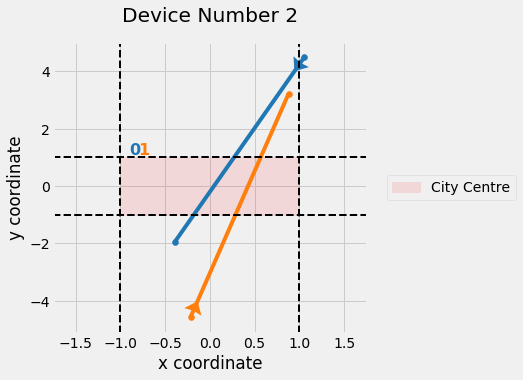

In [11]:
plot_device([2], data, seq)

Here is a device with three trajectories which **all occur to the southwest of the city centre**...

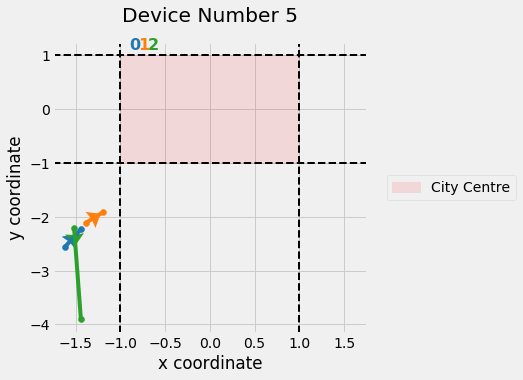

In [12]:
plot_device([5], data, seq)

In this device two of the trajectories are just **stationary points**...

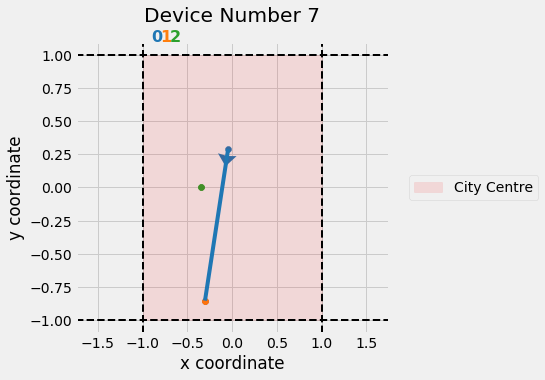

In [13]:
plot_device([7], data, seq)

And here a more complicated journey occurs, **starting in the city centre** before **heading north**, then **turning back**, and finally **out again**...

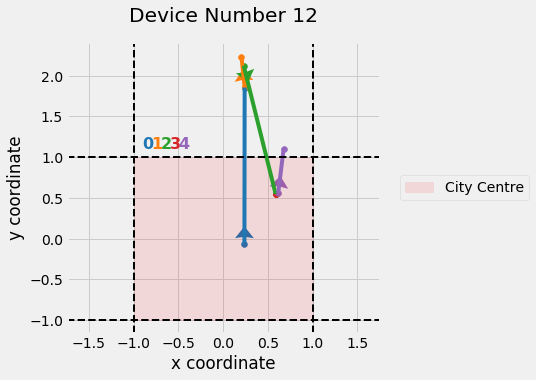

In [14]:
plot_device([12], data, seq)

We can also visualise the location of the **start points** for the **final trajectory in each device**. Here we can make out **roads going into Atlanta**, as well as a **ringroad around the city** and **areas of high population density in the city centre**.

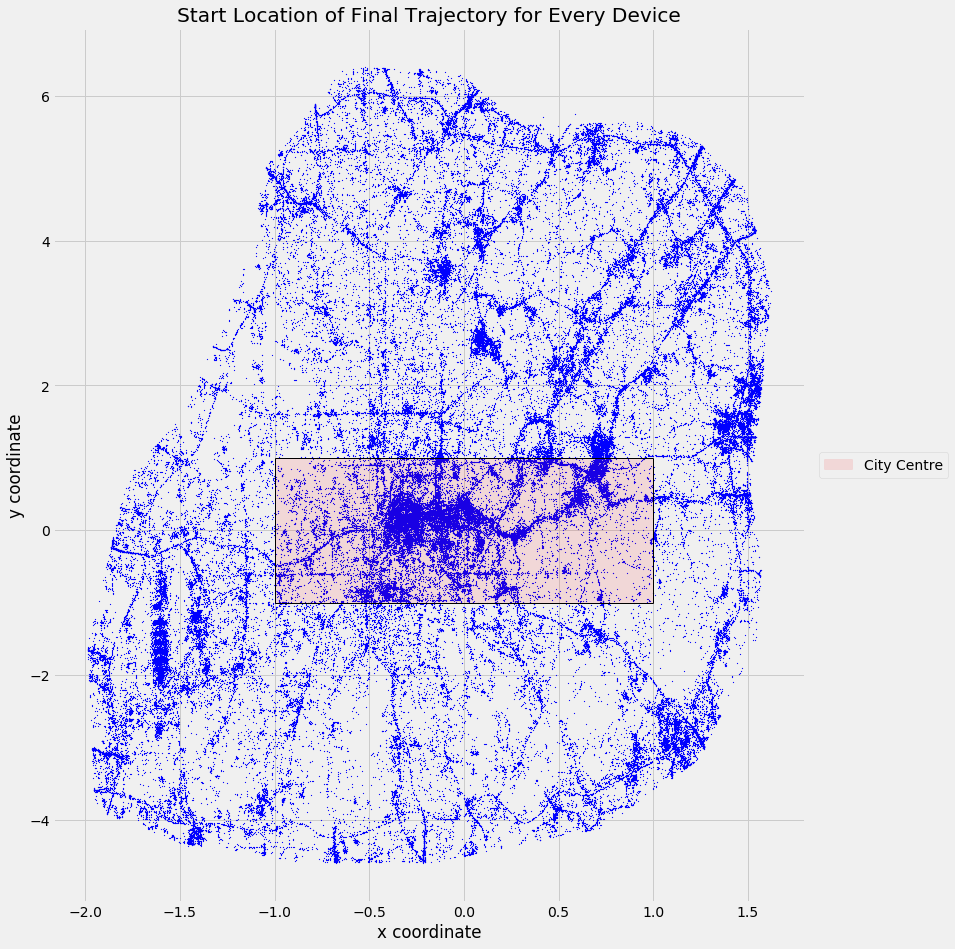

In [15]:
plt.figure(figsize=(12,15))
plt.scatter(final_states[:,4], final_states[:,5], s=.5, c='b')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Start Location of Final Trajectory for Every Device')
plt.vlines((-1,1), -1, 1, linewidth=1)
plt.hlines((-1,1), -1, 1, linewidth=1)
plt.fill_between(x=(-1,1), y1=(-1,-1), y2=(1,1), color='r', 
                 alpha=0.1, label='City Centre')
plt.legend(loc=7, bbox_to_anchor=(1.2,0.5))
plt.show()

We are going to predict whether each device's final trajectory ends up **inside or outside the city centre**. So let's plot whether these final trajectories go from **inside to outside**, **outside to inside**, or **do not change** in the training data:

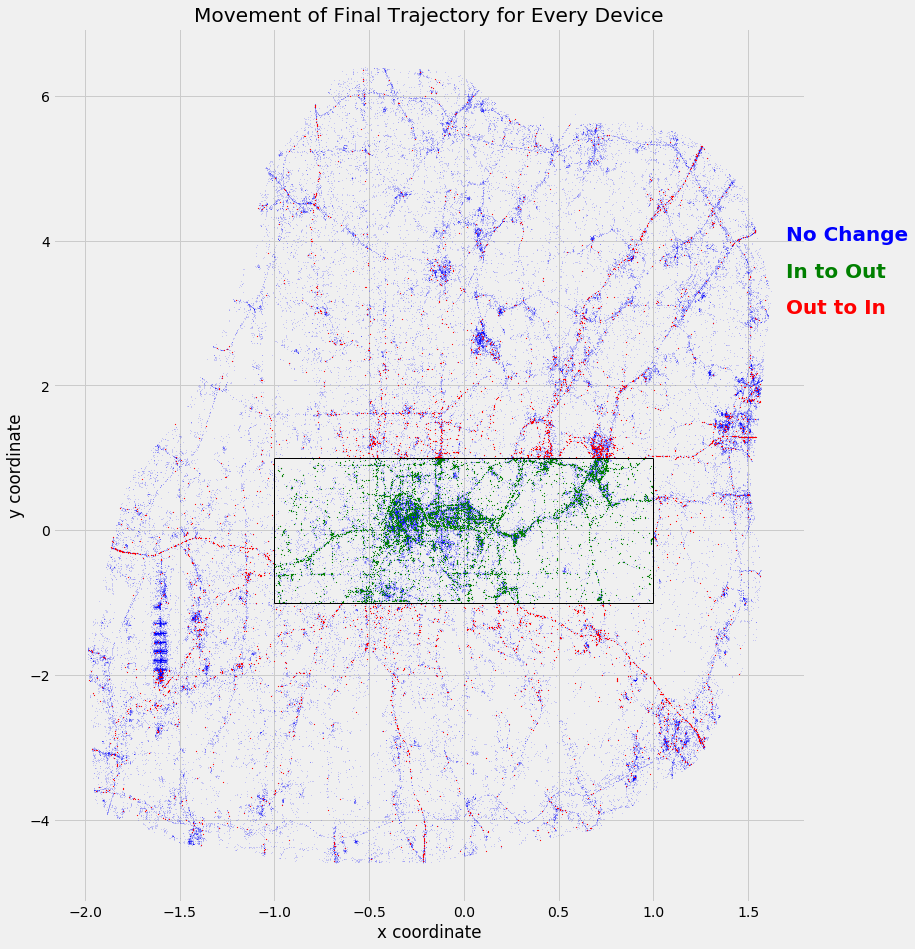

In [16]:
obs = [] #0 = No change, 1 = In to Out, 2 = Out to In
for i in range(n_devices):
    f = final_states[i]
    if np.abs(f[4]) <= 1 and np.abs(f[5]) <= 1: #starts in city centre
        if np.abs(f[6]) <= 1 and np.abs(f[7]) <= 1: #ends in city centre
            obs.append(0)
        else:
            obs.append(1)
    else:
        if np.abs(f[6]) <= 1 and np.abs(f[7]) <= 1:
            obs.append(2)
        else:
            obs.append(0)
obs= np.array(obs)

plt.figure(figsize=(12,15))
plt.scatter(final_states[obs==0][:,4], final_states[obs==0][:,5], s=.01, c='b')
plt.scatter(final_states[obs==1][:,4], final_states[obs==1][:,5], s=.5, c='g')
plt.scatter(final_states[obs==2][:,4], final_states[obs==2][:,5], s=.5, c='r')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Movement of Final Trajectory for Every Device')
plt.text(1.7,4,s='No Change', color='b', fontsize=20, weight='bold')
plt.text(1.7,3.5,s='In to Out', color='g', fontsize=20, weight='bold')
plt.text(1.7,3,s='Out to In', color='r', fontsize=20, weight='bold')
plt.vlines((-1,1), -1, 1, linewidth=1)
plt.hlines((-1,1), -1, 1, linewidth=1)
plt.show()

**There is some structure** - for example, it seems many of the trajectories that **move from outside the city centre to inside start on main roads** - this makes sense. 

**However**, it is clear that **we cannot predict the end location of each device's final trajectory using only the final trajectory itself**. We must **use all the trajectories for each device to predict the final trajectory**.

Therefore, since each device contains a **sequence of trajectories over time**, we will use a **Recurrent Neural Network (RNN)** to learn how devices are likely to move around the city.

### Building an RNN Model using TensorFlow

Let's **create training labels** for each device: 0 if the final trajectory ends outside the city centre, and 1 if it ends inside the city centre. Let's also split the data into our **training and validation sets**.

In [17]:
#training labels
labs = [1 if np.abs(f[6])<=1 and np.abs(f[7])<=1 else 0 for f in final_states]

#remove final endpoints from the training data (remove the information we're predicting!)
for i in range(n_devices):
    data[i][seq[i]-1][6:] = 0

In [18]:
#split training data into training and validation subsets
val_frac = .05                                 #fraction of data to use as validation
n = int(val_frac*n_devices)                    #n will be the number of devices usedfor validation

data_train, data_val = data[n:], data[:n]      #split data
labs_train, labs_val = labs[n:], labs[:n]      #split labels
seq_length_train, seq_length_val = seq[n:], seq[:n]

print('Training data has shape', data_train.shape)
print('Validation data has shape', data_val.shape)

Training data has shape (127360, 20, 8)
Validation data has shape (6703, 20, 8)


**Now let's build our RNN**. It will have **2 layers of LSTM (long short term memory) cells** with **10 cells in each layer**. A **final dense layer** will reduce the number of outputs to 2, corresponding to our training labels.

In [19]:
#LSTM RNN
n_inputs = 8        #number of features in each trajectory
n_layers=2          #number of layers of LSTM cells
n_neurons = 10      #number of cells in each layer
n_steps = 20        #each device has a possible 20 trajectories 
n_outputs=2         #either 0 or 1 depending on whether it's inside or outside the city centre

learning_rate = 0.012
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs]) #data
y = tf.placeholder(tf.int32, shape=[None]) #labels
seq_length = tf.placeholder(tf.int32, shape=[None]) #number of trajectories in each device

#build RNN
layers = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu) 
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32, 
                                    sequence_length=seq_length) #output of RNN
states = states[-1][1]
states = tf.concat(axis=1, values=states)

#add dense layer
final = tf.layers.dense(states, n_outputs) 

#use cross entropy to measure the loss
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=final)
loss = tf.reduce_mean(xentropy) 

#choose optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

#initialise
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


### Running the RNN

**Here we use the F1 score as our measure of the model**. This balances the **precision** and the **recall** of the model.

In [20]:
%%time
n_epochs = 50
batch_size = 500
epoch_list = []
train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []
precision = []
recall = []
f1_score = []
max_f1 = 0

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = data_train.shape[0]//batch_size
        for i in range(n_batches):
            X_batch = data_train[i*batch_size:i*batch_size+batch_size,:,:]
            seq_length_batch = seq_length_train[i*batch_size:i*batch_size+batch_size]
            labs_batch = labs_train[i*batch_size:i*batch_size+batch_size]
            sess.run(training_op, 
                     feed_dict={X: X_batch, y: labs_batch, seq_length: seq_length_batch})
            
        #loss   
        loss_tr = loss.eval(feed_dict={X: X_batch, y: labs_batch, seq_length: seq_length_batch})
        loss_val = loss.eval(feed_dict={X: data_val, y: labs_val, seq_length: seq_length_val})
        
        #accuracy
        results_tr = final.eval(feed_dict={X: X_batch, seq_length: seq_length_batch})
        results_val = final.eval(feed_dict={X: data_val, seq_length: seq_length_val})
        Z_tr = np.argmax(results_tr, axis=1)
        Z_val = np.argmax(results_val, axis=1)

        #F1 score
        tp = 0 
        fp = 0
        fn = 0
        for i, item in enumerate(Z_val):
            if item == 0 and item == labs_val[i]:
                pass
            elif item == 0 and item != labs_val[i]:
                fn += 1
            elif item == 1 and item == labs_val[i]:
                tp += 1
            elif item == 1 and item != labs_val[i]:
                fp += 1

        p = tp/(tp+fp) #precision
        r = tp/(tp+fn) #recall
        f1 = 2*((p*r)/(p+r)) #f1 score
        print('Epoch:', epoch, 
              'F1 Score:', np.round(f1,3), 
              'Precision:', np.round(p,3), 
              'Recall:', np.round(r,3))  
        f1_score.append(f1)
        precision.append(p)
        recall.append(r)
        
        #save best model
        if f1 > max_f1:
            saver.save(sess, "./models/best_model.ckpt")
            max_f1 = f1
                
        epoch_list.append(epoch)
        train_loss.append(loss_tr)
        validation_loss.append(loss_val)
        train_accuracy.append((Z_tr == labs_batch).sum()/batch_size)
        validation_accuracy.append((Z_val == labs_val).sum()/len(labs_val))

Epoch: 0 F1 Score: 0.847 Precision: 0.836 Recall: 0.858
Epoch: 1 F1 Score: 0.857 Precision: 0.842 Recall: 0.872
Epoch: 2 F1 Score: 0.854 Precision: 0.887 Recall: 0.823
Epoch: 3 F1 Score: 0.869 Precision: 0.892 Recall: 0.846
Epoch: 4 F1 Score: 0.87 Precision: 0.912 Recall: 0.833
Epoch: 5 F1 Score: 0.871 Precision: 0.912 Recall: 0.834
Epoch: 6 F1 Score: 0.879 Precision: 0.901 Recall: 0.859
Epoch: 7 F1 Score: 0.88 Precision: 0.902 Recall: 0.859
Epoch: 8 F1 Score: 0.881 Precision: 0.911 Recall: 0.854
Epoch: 9 F1 Score: 0.884 Precision: 0.911 Recall: 0.859
Epoch: 10 F1 Score: 0.883 Precision: 0.913 Recall: 0.855
Epoch: 11 F1 Score: 0.884 Precision: 0.916 Recall: 0.854
Epoch: 12 F1 Score: 0.883 Precision: 0.917 Recall: 0.853
Epoch: 13 F1 Score: 0.883 Precision: 0.911 Recall: 0.856
Epoch: 14 F1 Score: 0.884 Precision: 0.909 Recall: 0.859
Epoch: 15 F1 Score: 0.885 Precision: 0.909 Recall: 0.862
Epoch: 16 F1 Score: 0.883 Precision: 0.908 Recall: 0.859
Epoch: 17 F1 Score: 0.882 Precision: 0.904 

**Now let's plot the loss**:

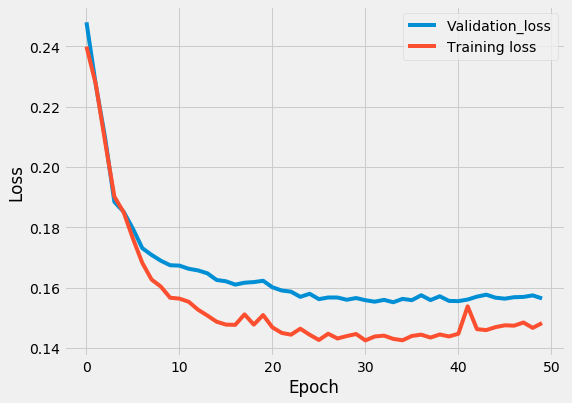

In [21]:
plt.figure(figsize=(8,6))
plt.plot(epoch_list, validation_loss, label='Validation_loss')
plt.plot(epoch_list, train_loss, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**The accuracy**:

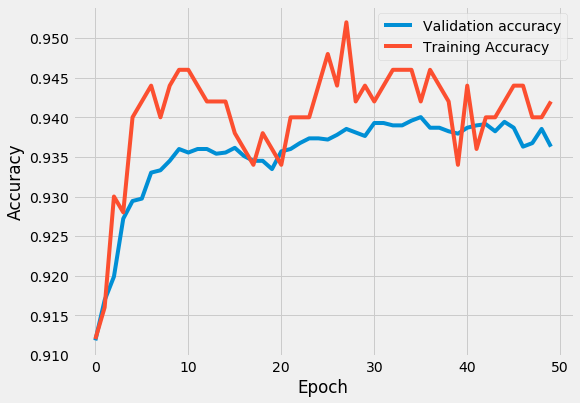

In [22]:
plt.figure(figsize=(8,6))
plt.plot(epoch_list, validation_accuracy, label='Validation accuracy')
plt.plot(epoch_list, train_accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

And the **Precision, Recall and F1 Score** on the validation data:

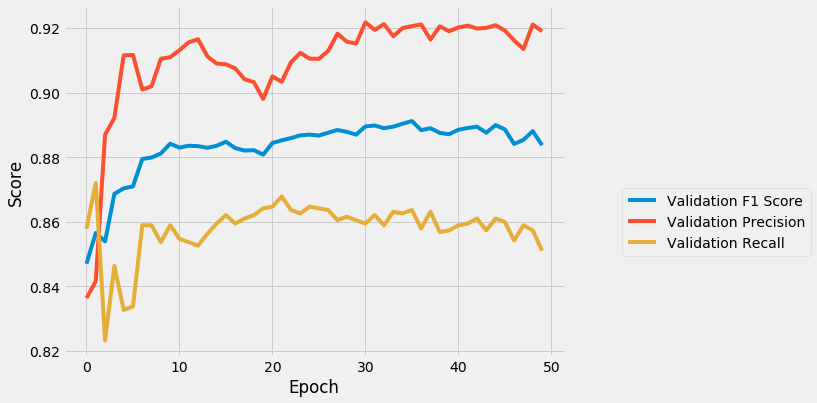

In [23]:
plt.figure(figsize=(8,6))
plt.plot(epoch_list, f1_score, label='Validation F1 Score')
plt.plot(epoch_list, precision, label='Validation Precision')
plt.plot(epoch_list, recall, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.1,0.5))
plt.show()

### Conclusions

- The RNN is able to achieve an **accuracy of ~94%** and an **F1 Score of 0.89**. In the 2019 EY SmartCities Data Challenge, the top scoring model globally achieved an F1 score of 0.895, **so this is pretty good**!

- The model is able to learn by improving its Precision, but not its Recall. Hence **it is good at learning when a device is going to leave the city centre**, but **has trouble learning when it is going to enter the city centre from outside**. 

- To show this visually, here we plot the final trajectory of all the devices in the validation dataset that **move across the city centre border**, and **color them by whether our prediction is correct**. It is clear that **many of the devices moving from IN to OUT are correctly predicted**, whereas few of the devices moving from OUT to IN are correctly predicted.

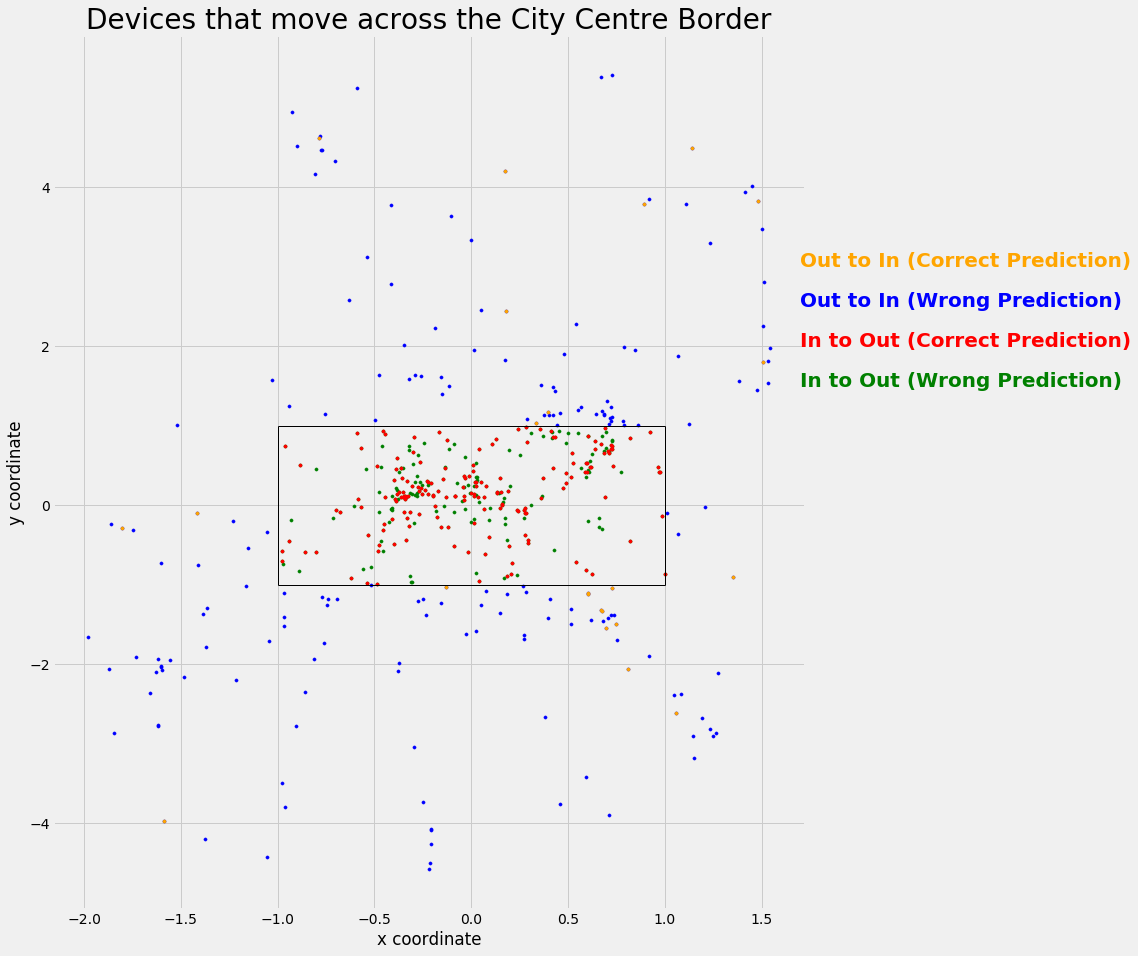

In [25]:
obs_val = obs[:n]
final_states_val = final_states[:n]

correct = np.zeros(n)
for i in range(n):
    if obs_val[i] == 1 and Z_val[i] == 0:
        correct[i] = 1
    elif obs_val[i] == 2 and Z_val[i] == 1:
        correct[i] = 2
        
plt.figure(figsize=(12,15))
plt.scatter(final_states_val[obs_val==1][:,4], final_states_val[obs_val==1][:,5], s=10, c='g')
plt.scatter(final_states_val[obs_val==2][:,4], final_states_val[obs_val==2][:,5], s=10, c='b')
plt.scatter(final_states_val[correct==1][:,4], final_states_val[correct==1][:,5], s=10, c='r')
plt.scatter(final_states_val[correct==2][:,4], final_states_val[correct==2][:,5], s=10, c='orange')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Devices that move across the City Centre Border', fontsize=28)
plt.text(1.7,1.5,s='In to Out (Wrong Prediction)', color='g', fontsize=20, weight='bold')
plt.text(1.7,2.5,s='Out to In (Wrong Prediction)', color='b', fontsize=20, weight='bold')
plt.text(1.7,2,s='In to Out (Correct Prediction)', color='r', fontsize=20, weight='bold')
plt.text(1.7,3,s='Out to In (Correct Prediction)', color='orange', fontsize=20, weight='bold')
plt.vlines((-1,1), -1, 1, linewidth=1)
plt.hlines((-1,1), -1, 1, linewidth=1)
plt.show()

Similarly, we can plot the final trajectories of all the devices that **do not move across the city centre border**, and again color them by whether our prediction is correct.

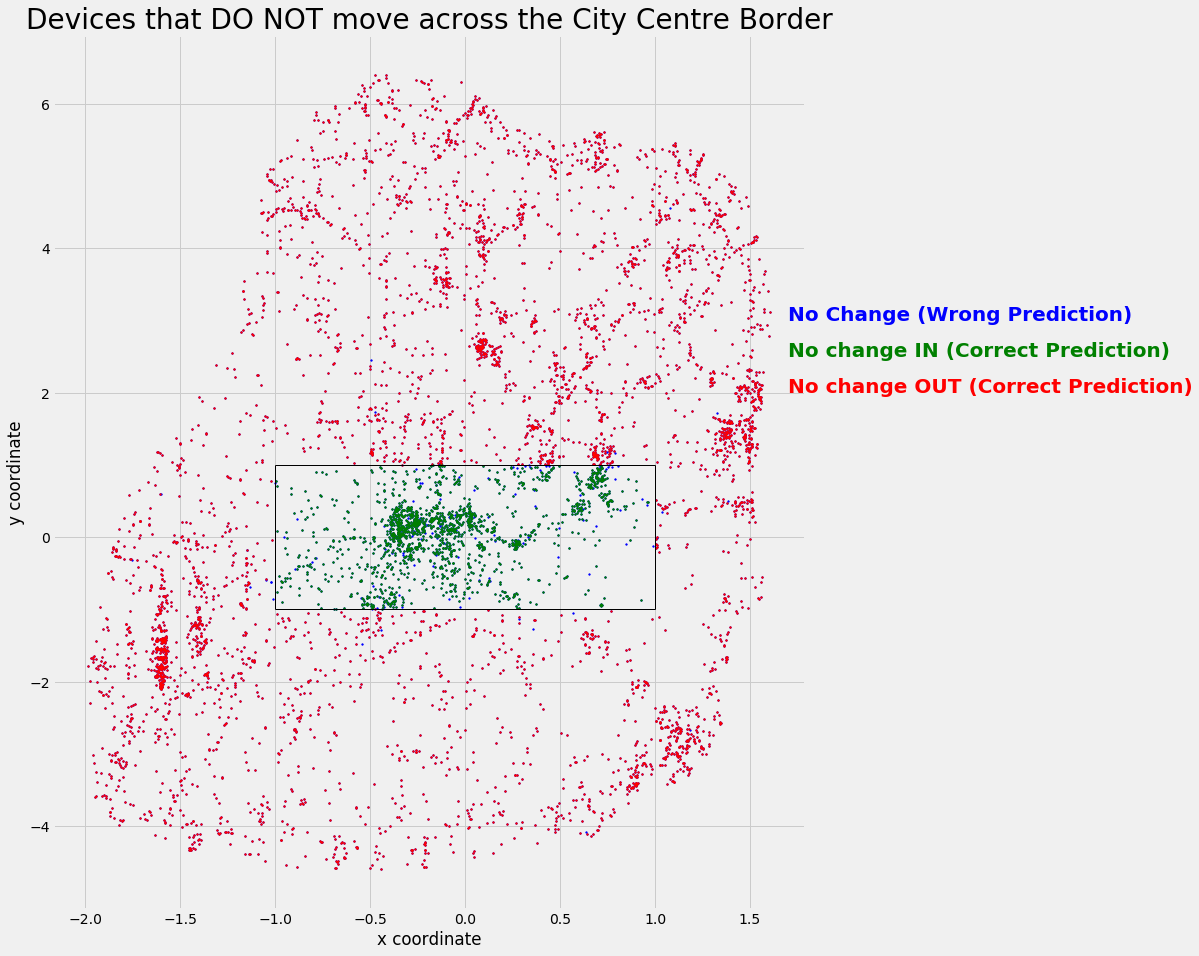

In [27]:
correct = np.zeros(n)
for i in range(n):
    if obs_val[i] == 0 and Z_val[i] == 0 and labs_val[i] == 0:
        correct[i] = 1
    elif obs_val[i] == 0 and Z_val[i] == 1 and labs_val[i] == 1:
        correct[i] = 2
        
plt.figure(figsize=(12,15))
plt.scatter(final_states_val[obs_val==0][:,4], final_states_val[obs_val==0][:,5], s=3, c='b')
plt.scatter(final_states_val[correct==1][:,4], final_states_val[correct==1][:,5], s=3, c='r')
plt.scatter(final_states_val[correct==2][:,4], final_states_val[correct==2][:,5], s=3, c='g')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Devices that DO NOT move across the City Centre Border', fontsize=28)
plt.text(1.7,3,s='No Change (Wrong Prediction)', color='b', fontsize=20, weight='bold')
plt.text(1.7,2,s='No change OUT (Correct Prediction)', color='r', fontsize=20, weight='bold')
plt.text(1.7,2.5,s='No change IN (Correct Prediction)', color='g', fontsize=20, weight='bold')
plt.vlines((-1,1), -1, 1, linewidth=1)
plt.hlines((-1,1), -1, 1, linewidth=1)
plt.show()

Clearly, further work on this model should aim to address this imbalance between the Precision and Recall.

**Thanks for reading!**